# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Experiment Analysis </strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
This notebook contains analysis of experiment results. Most experiments consist of using testperanto to generate multiple datasets of artificial language. We then train pairwise on these subsets of these datasets, allowing to train while varying corpus length.
</p>


# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Table of Contents </strong> </p>


<table style="margin-left: auto; margin-right: auto; width: 85%; border-collapse: collapse; font-family: 'Georgia', serif; font-size: 105%; border: 2px solid #333;">
    <tr>
        <td>No</td>
        <td>Contents</td>
        <td>No</td>
        <td>Contents</td>
    </tr>
    <tr>
        <td>1</td>
        <td><a href="#1"> Basic Functionality</a></td>
        <td>3</td>
        <td><a href="#3">Data Variability Analysis</a></td>
    </tr>
    <tr>
        <td>2</td>
        <td><a href="#2">SVO Permutation Analysis</a></td>
        <td>4</td>
        <td><a href="#4"> ... </a></td>
    </tr>
</table>


<a id='1'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Basic Functionality </strong> </p>


In [150]:
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import tensorflow as tf

from config import *
from helper import format_number

import warnings
warnings.filterwarnings("ignore")

In [93]:
"""
Helper Functions for Creating DataFrame.
"""

def get_score_path(config, corp_len, combo):
    ### gets path to scores associated with config, corp_len, combo
    form_len    = format_number(corp_len)
    folder_name = f"{'_'.join(combo)}_{form_len}"
    result_dir  = f"{config.RESULTS_PATH}/{folder_name}"
    return        f"{result_dir}/scores"

def get_tb_path(config, corp_len, combo):
    ### gets path to tensorboard associated with config, corp_len, combo
    form_len    = format_number(corp_len)
    folder_name = f"{'_'.join(combo)}_{form_len}"
    result_dir  = f"{config.RESULTS_PATH}/{folder_name}"
    return      f"{result_dir}/tensorboard_logs"

def print_tb_cmd(config, corp_len, combo):
    ### prints cmd to open tensorboard 
    path = get_tb_path(config, corp_len, combo)
    command = f"tensorboard --logdir {path} --port=6008"
    print(command)

def add_data(config, corp_len, combo):
    ### adds data associated with config, corp_len, combo
    scores  = get_score_path(config, corp_len, combo)
    tb_path = get_tb_path(config, corp_len, combo)

    try: 
        with open(scores) as f:
            contents = eval(f.read())
            bleu = contents[0]['score']
            chrF2 = contents[1]['score']

        num_steps = None
        for section in ['train']: # for now just getting num_steps 'train_inner', 'valid']:
            tb_path = f"{tb_path}/{section}"
            for event_file in os.listdir(tb_path):
                event_path = os.path.join(tb_path, event_file)
                last = list(tf.compat.v1.train.summary_iterator(event_path))[-1]
                num_steps = last.step

        return [corp_len, combo[0], combo[1], bleu, chrF2, num_steps]

    except Exception:
        # hasn't been processed yet
        return None 

def create_df(config):
    ### creates a results.csv based on config experiment results
    all_combos = config.combos + [combo[::-1] for combo in config.combos] 
    data = [add_data(config, corp_len, combo)
            for corp_len in config.corp_lens 
            for combo in all_combos]

    # filter out unprocessed results
    data = [d for d in data if d is not None]
    df = pd.DataFrame(data, columns=['corpus_length', 'src', 'tgt', 'bleu', 'chrF2', 'num_steps'])
    csv_path = f"{config.EXP_PATH}/results.csv"
    df.to_csv(csv_path, index=False)

In [94]:
"""
get_data(exp_name) updates/fetches the data for assoc. experiment
"""

def get_data(exp_name='svo_perm'):
    """
    Returns pd.DataFrame with results associated with experiment exp_name

    exp_name should be either svo_perm or data_variability (for now)
    """
    if exp_name == "svo_perm":
        config = SVOConfig()
    
    elif exp_name == 'data_variability':
        config = VarConfig()
    
    else:
        raise ValueError(f"Experiment name must be svo_perm or data_variability")
    
    create_df(config)
    df_path = f"{config.EXP_PATH}/results.csv"
    
    try:
        df = pd.read_csv(df_path)
    
    except:
        print(f"{exp_name} hasn't been fully analyzed yet.")
   
    df['name']  = df['src'].str.lower() + "_" + df['tgt'].str.lower()
    df['is_id'] = ((df['src'] + "_id" == df['tgt']) | (df['src'] == df['tgt'] + '_id'))
    df['last'] = df['tgt'].apply(lambda x : x[-1])
    df['normalized_steps'] = df['num_steps'] / df['corpus_length'] # prop to num_epochs

    return df 

groupby_name = lambda df : df.groupby('name').apply(lambda x : x)

In [95]:
def plot_scores(df, score='bleu', selected_names=None):
    # group by name then find all corp_len, score pairs
    grouped = df.groupby('name').apply(lambda x: list(zip(x['corpus_length'], x[score])))
    data = grouped.to_dict()

    plt.figure(figsize=(14, 6))

    # Colors and markers setup
    colors = ['#00BFFF', '#228B22', '#FF6347', '#7851A9', '#FFA500', '#008080', '#708090']
    color_cycle = itertools.cycle(colors)
    markers = ['o', 's', '^', 'x', '*', '+', 'd']
    marker_cycle = itertools.cycle(markers)

    # Find common corpus length C
    common_lengths = set.intersection(*(set(map(lambda x: x[0], v)) for v in data.values()))
    C = max(common_lengths)

    # Calculate scores at C and filter models
    scores_at_C = {name: next(score for length, score in points if length == C) for name, points in data.items()}

    handles = []

    for name, points in data.items():
        if selected_names is not None and name not in selected_names:
            continue

        lengths, scores = zip(*points)
        color = next(color_cycle)
        marker = next(marker_cycle)
        line, = plt.plot(lengths, scores, label=f"{name}: {scores_at_C.get(name, 0)}", color=color, marker=marker, linestyle='-')
        handles.append(line)

    # Sorting the legend based on score at C
    sorted_handles = sorted(zip(scores_at_C.values(), handles), key=lambda x: x[0], reverse=True)
    handles = [handle for _, handle in sorted_handles]

    # Placing legend outside the plot
    plt.legend(handles, [h.get_label() for h in handles], loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

    # Plot titles and labels
    name = "BLEU" if score == 'bleu' else 'chrF2'
    plt.title(f'{name} Scores vs. Corpus Lengths')
    plt.xlabel("Corpus Size")
    plt.ylabel(f"{name} Score")

    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()

def two_factor_plot(df, tgt_language):
    """
    Plots a two-factor barplot of BLEU scores with source language and corpus length as factors for a given target language.

    :param df: DataFrame containing the columns 'src', 'tgt', 'corpus_length', and 'bleu'.
    :param tgt_language: The target language for which the plot is to be made.
    """
    # Filter the DataFrame for the specified target language
    filtered_df = df[df['tgt'].str.lower() == tgt_language.lower()]

    # Setting the aesthetics for the plot
    sns.set(style="whitegrid")

    # Creating a figure
    plt.figure(figsize=(8, 6))

    # Creating a bar plot
    bar_plot = sns.barplot(x="corpus_length", y="bleu", hue="src", data=filtered_df)

    # Enhancing the plot
    plt.title(f'BLEU Scores by SRC/Corp Size for {tgt_language.upper()}', fontsize=18)
    plt.xlabel('Corpus Length', fontsize=14)
    plt.ylabel('BLEU Score', fontsize=14)
    plt.legend(title='Source Language', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.show()

def plot_score_vs_steps(df, score='bleu', selected_names=None):
    # Ensure that the score and size columns exist
    if score not in df.columns:
        raise ValueError(f"Score '{score}' not found in DataFrame columns.")
    if 'corpus_length' not in df.columns:
        raise ValueError("Column 'corpus_length' not found in DataFrame columns.")

    plt.figure(figsize=(12,8))

    # Create a color mapping based on unique 'size' values
    unique_sizes = df['corpus_length'].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_sizes)))
    size_color_map = dict(zip(unique_sizes, colors))

    # Prepare legend handles
    legend_handles = []

    for size in unique_sizes:
        # Create a scatter plot for each size for legend purpose (without actual data)
        scatter = plt.scatter([], [], color=size_color_map[size], label=f"Size {size}")
        legend_handles.append(scatter)

    for name, group in df.groupby('name'):
        # Filter based on selected names, if provided
        if selected_names is not None and name not in selected_names:
            continue

        for size in unique_sizes:
            # Filter the group for each size
            size_group = group[group['corpus_length'] == size]

            # Scatter plot for num_steps vs score, with color based on size
            plt.scatter(size_group['num_steps'], size_group[score], color=size_color_map[size])

            # Annotating each point with its name and corpus_length
            for _, row in size_group.iterrows():
                plt.annotate(f"{name}", (row['num_steps'], row[score]), fontsize=6)  # Smaller font size

    # Set labels and title
    score_label = "BLEU" if score == 'bleu' else 'chrF2'
    plt.title(f'{score_label} Scores vs. Number of Steps')
    plt.xlabel("Number of Steps")
    plt.ylabel(f"{score_label} Score")

    # Show legend and grid
    plt.legend(handles=legend_handles)
    plt.grid(True)
    plt.show()

def plot_by_len(df, corp_len, score='bleu'):
    data = df[df['corpus_length'] == corp_len][['name', score]].sort_values(by=score, ascending=True)
    
    if len(data) > 0:
        plt.figure(figsize=(8, 8))
        sns.barplot(x=score, y='name', data=data, palette='viridis')
        plt.title(f"{score} by model for corpus size {corp_len}")
        plt.xlabel(f"{score}")
        plt.ylabel('model')
        plt.grid(axis='x')
        plt.show()


def histplot(x, bins=30, xlabel=None, title=None):
    # distribution of numerical
    plt.figure(figsize = (8,6))
    p = sns.histplot(x, bins=bins, kde=True, fill=True,
                    edgecolor="black", linewidth=3
                    )

    p.axes.lines[0].set_color("orange")
    
    if xlabel is None:
        xlabel = str(x)
        
    if title is None:
        title = f"{xlabel} Distribution"
    
    plt.ylabel("Count", fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.show()
    return p

def countplot(x, xlabel, title=None):
    # distribution of categorical
    plt.figure(figsize = (8,6))
    p = sns.countplot(x = x, order = sorted(set(x)))
    
    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 15, color = "black", 
                    bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                          "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})
        
    if title is None:
        title = f"Breakdown of {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_ylabel("Count",fontsize = 20)
    p.axes.set_xlabel(xlabel, fontsize = 20) 
    plt.show()  
    return p 

def violinplot(x, y, xlabel, ylabel, title=None): 
    # x is categorical, y is numerical 
    plt.figure(figsize = (8, 6))
        
    p = sns.violinplot(x = x, y = y, order = sorted(set(x)),
                       linewidth = 3, edgecolor = "black")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_xlabel(xlabel, fontsize = 20)
    p.axes.set_ylabel(ylabel, fontsize = 20)
    plt.show()
    return p

def kdeplot(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(8, 6))
    
    p = sns.kdeplot(x=x, y=y, fill=True)
    
    if title is None:
        title = f"{ylabel} by {xlabel}"
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def scatter(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(8, 6))
    sns.set(style='ticks')
    sns.set_context("poster")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p = sns.regplot(x=x, y=y)
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

<a id='2'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> SVO Permutation Analysis </strong> </p>

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
In the SVO permutation experiment, we generate basic sentences that are the 3! = 6 permutations of svo (svo, sov, ...). We train pairwise, along with the identity element, giving us 2 (6C2 + 6) = 42 models at each corpus length. The corpus lengths we trained were 2000, 4000, ..., 32000.
</p>


In [96]:
config = SVOConfig()
df = get_data()

df.head()

,corpus_length,src,tgt,bleu,chrF2,num_steps,name,is_id,last,normalized_steps
0,2000,SVO,SOV,16.9,51.0,2568,svo_sov,False,V,1.284
1,2000,SVO,VSO,26.6,56.7,3918,svo_vso,False,O,1.959
2,2000,SVO,VOS,24.6,56.8,4062,svo_vos,False,S,2.031
3,2000,SVO,OSV,19.0,52.4,2940,svo_osv,False,V,1.470
4,2000,SVO,OVS,22.6,55.1,3438,svo_ovs,False,S,1.719


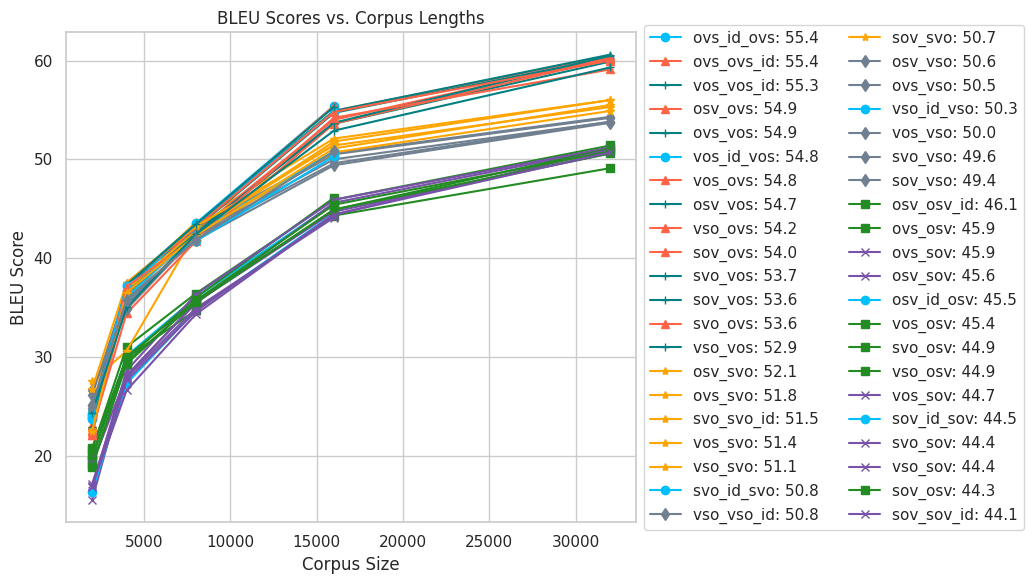

In [97]:
plot_scores(df)

**Analysis:** <br>
- bleu overall is increasing and concave
- as corpus size increases, we converge to 3 groups
- the 3 groups are exactly the last elem of the tgt 


Now let's do an analysis by breaking down into the various corpus lengths.

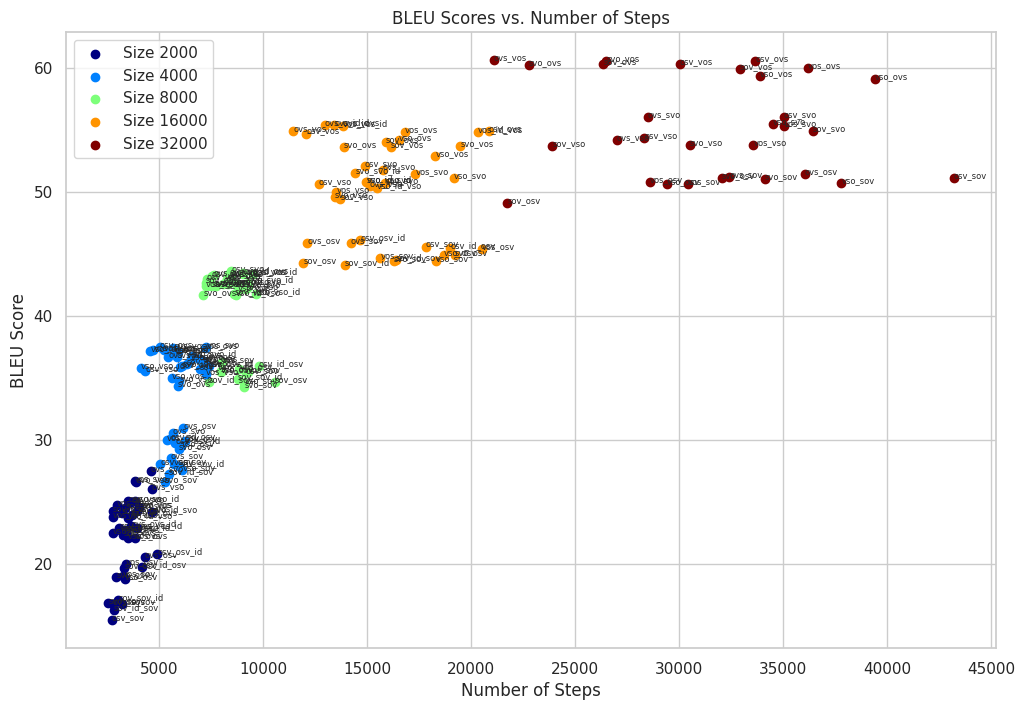

In [98]:
plot_score_vs_steps(df)

**Analysis:**
- Number of steps is not a big deal anymore, i.e. things are prob being trained properly

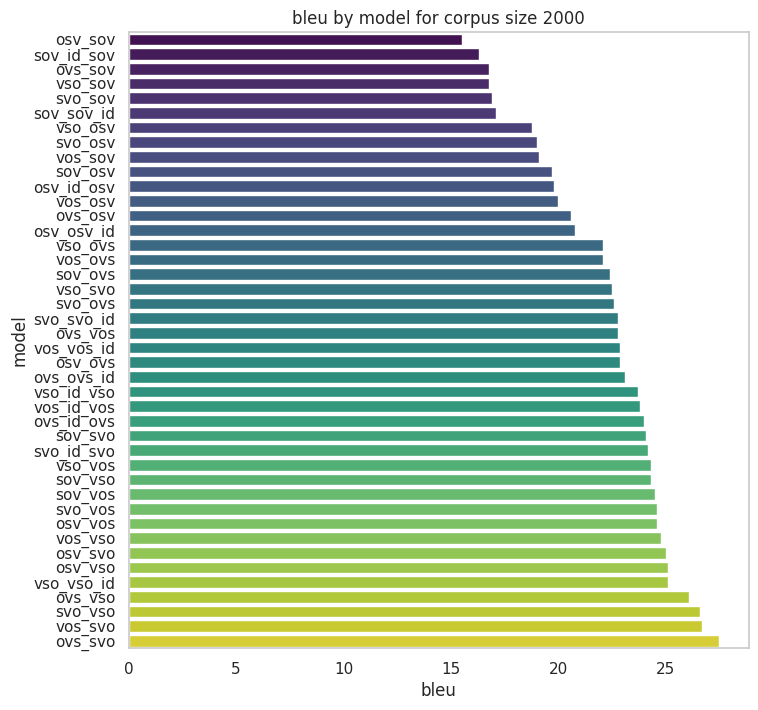

In [99]:
plot_by_len(df, 2000)

In [107]:
df_2k = df[(df['corpus_length'] == 2000) & (df['is_id'] == False)].drop(['normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_2k.head()

,src,tgt,bleu,num_steps,name,is_id,last
0,SVO,SOV,16.9,2568,svo_sov,False,V
1,SVO,VSO,26.6,3918,svo_vso,False,O
2,SVO,VOS,24.6,4062,svo_vos,False,S
3,SVO,OSV,19.0,2940,svo_osv,False,V
4,SVO,OVS,22.6,3438,svo_ovs,False,S


In [101]:
df_2k.describe()['bleu']

count    30.000000
mean     22.293333
std       3.282234
min      15.500000
25%      19.775000
50%      22.700000
75%      24.600000
max      27.500000
Name: bleu, dtype: float64

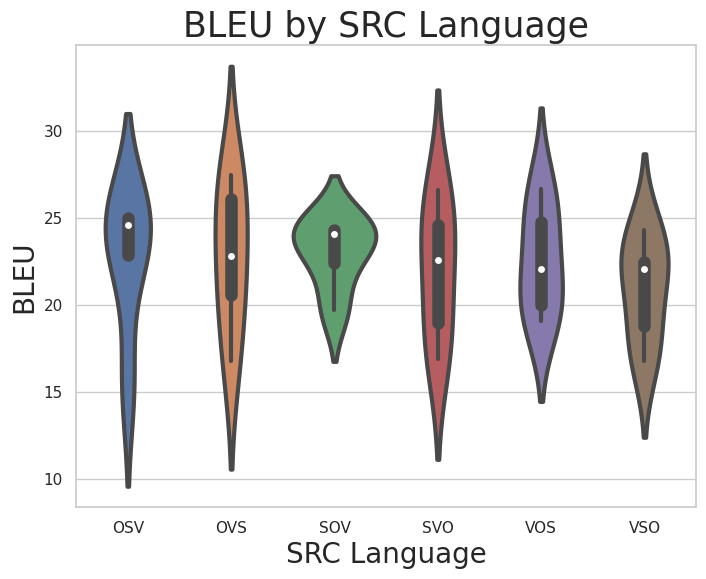

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [102]:
violinplot(df_2k['src'], df_2k['bleu'], xlabel = "SRC Language", ylabel= 'BLEU')

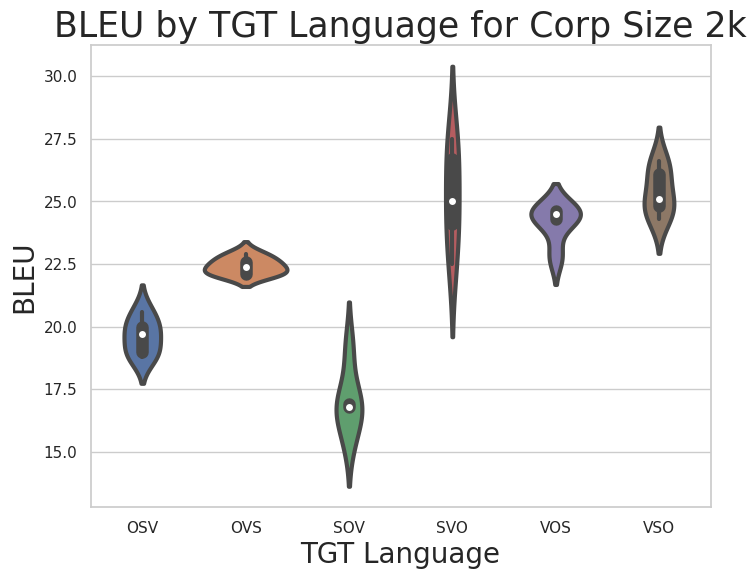

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 2k'}, xlabel='TGT Language', ylabel='BLEU'>

In [145]:
violinplot(df_2k['tgt'], df_2k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 2k')

**Analysis:**
- TGT language seems to be the thing that matters, since the variance in results is less
- SVO, VOS, VSO perform well, then OVS, OSV, SOV


Let's formalize this.

In [104]:
grouped = df_2k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

,src,Mean,Range,Variance
0,OSV,22.62,9.6,16.627
1,OVS,22.76,10.7,18.453
2,SOV,23.00,4.8,4.100
3,SVO,21.94,9.7,15.818
4,VOS,22.54,7.6,10.223
5,VSO,20.90,7.5,9.195


In [105]:
grouped = df_2k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values("tgt")

,tgt,Mean,Range,Variance
0,OSV,19.62,1.8,0.542
1,OVS,22.42,0.8,0.117
2,SOV,17.02,3.6,1.687
3,SVO,25.16,5.0,4.018
4,VOS,24.16,1.8,0.593
5,VSO,25.38,2.3,0.897


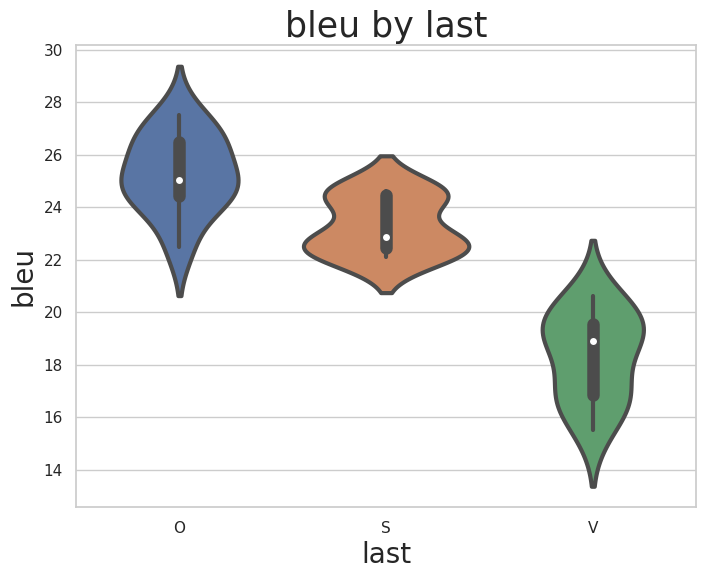

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [110]:
violinplot(df_2k['last'], df_2k['bleu'], xlabel = "last", ylabel='bleu')

Let's see if these trends persist as we increase corpus length.

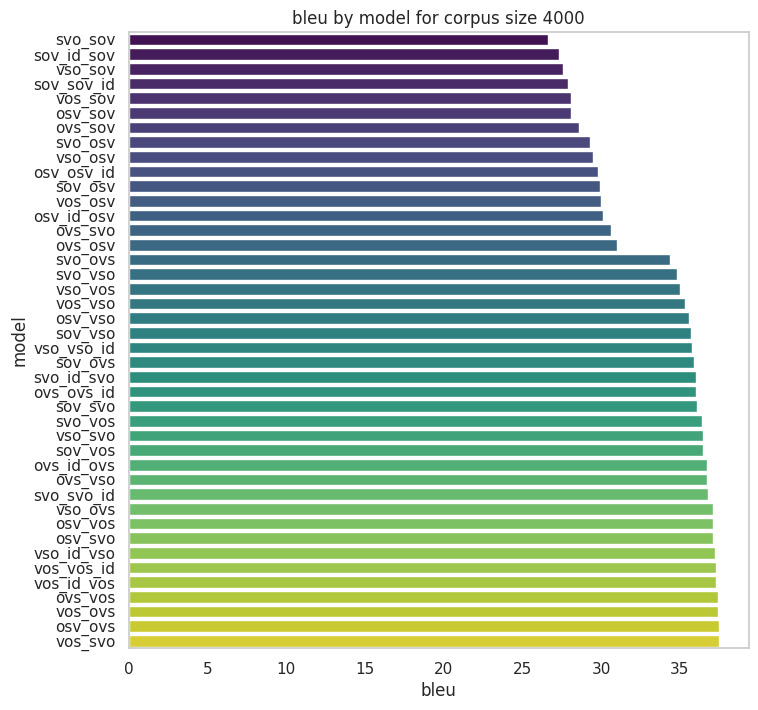

In [111]:
plot_by_len(df, 4000)

In [112]:
df_4k = df[(df['corpus_length'] == 4000) & (df['is_id'] == False)].drop(['is_id', 'normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_4k.head()

,src,tgt,bleu,num_steps,name,last
42,SVO,SOV,26.6,5291,svo_sov,V
43,SVO,VSO,34.8,5984,svo_vso,O
44,SVO,VOS,36.4,7172,svo_vos,S
45,SVO,OSV,29.3,5951,svo_osv,V
46,SVO,OVS,34.4,5918,svo_ovs,S


In [113]:
df_4k.describe()['bleu']

count    30.000000
mean     33.643333
std       3.738678
min      26.600000
25%      29.925000
50%      35.450000
75%      36.650000
max      37.500000
Name: bleu, dtype: float64

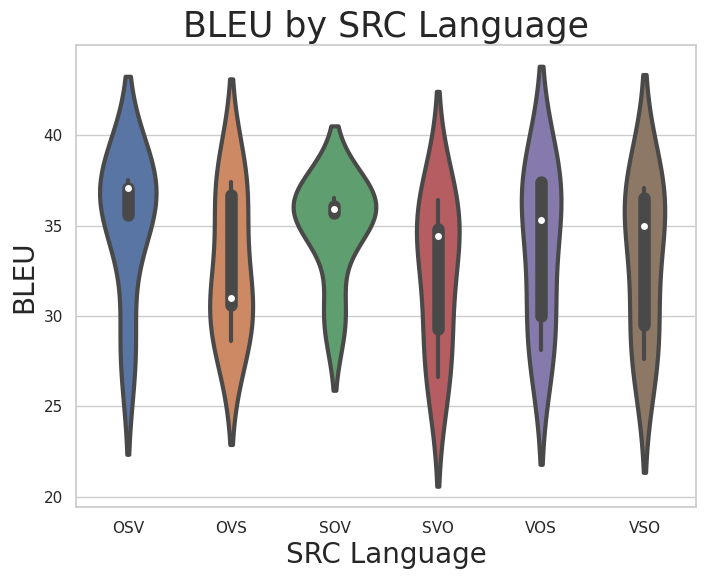

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [114]:
violinplot(df_4k['src'], df_4k['bleu'], xlabel = "SRC Language", ylabel= 'BLEU')

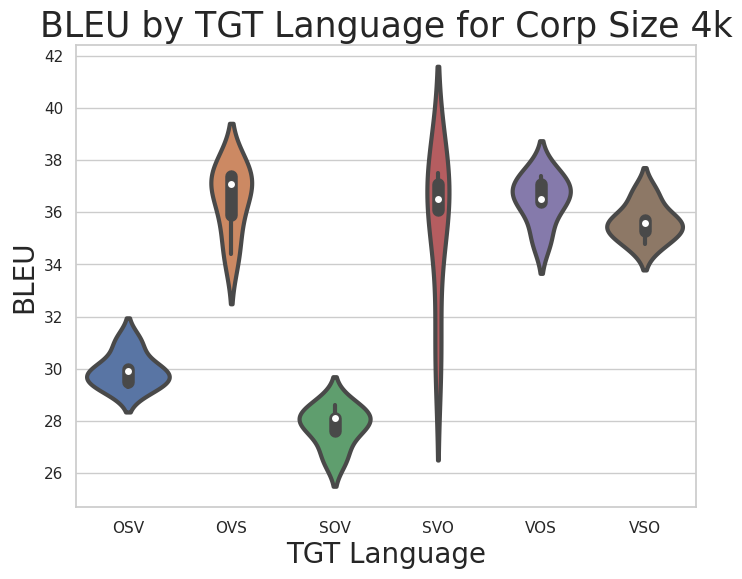

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 4k'}, xlabel='TGT Language', ylabel='BLEU'>

In [146]:
violinplot(df_4k['tgt'], df_4k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 4k')

**Analysis:**
- This looks remarkably similar
- The general pattern of what does better/worse remains
- SVO still has a decent amount of variance, which is interesting

In [116]:
grouped = df_4k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

,src,Mean,Range,Variance
0,OSV,35.08,9.4,15.752
1,OVS,32.86,8.8,15.518
2,SOV,34.82,6.6,7.652
3,SVO,32.30,9.8,17.240
4,VOS,33.66,9.4,18.933
5,VSO,33.14,9.5,18.593


In [117]:
grouped = df_4k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('tgt')

,tgt,Mean,Range,Variance
0,OSV,29.94,1.7,0.433
1,OVS,36.46,3.1,1.733
2,SOV,27.80,2.0,0.575
3,SVO,35.56,6.9,7.978
4,VOS,36.48,2.4,0.857
5,VSO,35.62,1.9,0.487


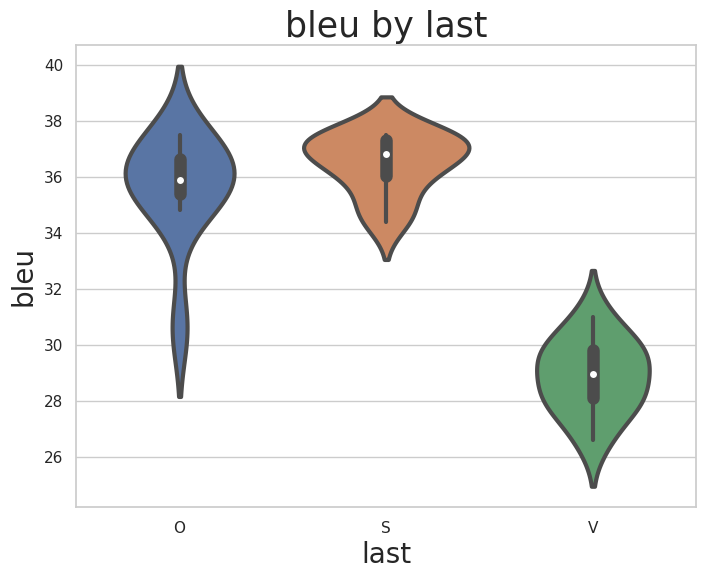

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [118]:
violinplot(df_4k['last'], df_4k['bleu'], xlabel = "last", ylabel='bleu')

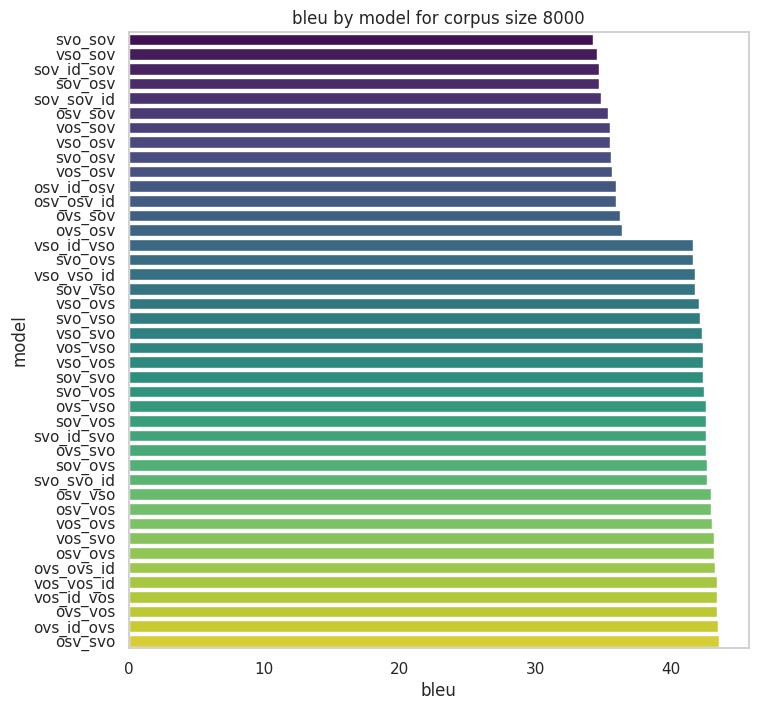

In [119]:
plot_by_len(df, 8000)

In [120]:
df_8k = df[(df['corpus_length'] == 8000) & (df['is_id'] == False)].drop(['is_id', 'normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_8k.head()

,src,tgt,bleu,num_steps,name,last
84,SVO,SOV,34.3,9100,svo_sov,V
85,SVO,VSO,42.2,9180,svo_vso,O
86,SVO,VOS,42.5,7620,svo_vos,S
87,SVO,OSV,35.6,7960,svo_osv,V
88,SVO,OVS,41.7,7140,svo_ovs,S


In [121]:
df_8k.describe()['bleu']

count    30.000000
mean     40.226667
std       3.517144
min      34.300000
25%      35.850000
50%      42.350000
75%      42.675000
max      43.600000
Name: bleu, dtype: float64

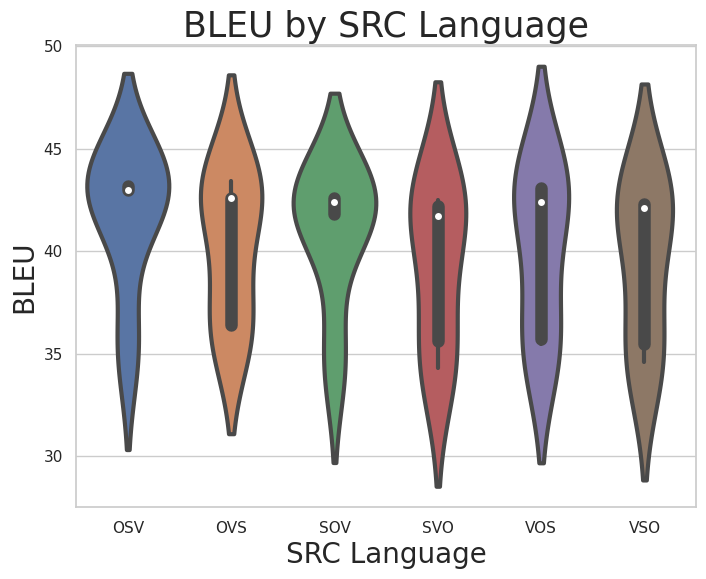

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [122]:
violinplot(df_8k['src'], df_8k['bleu'], xlabel = 'SRC Language', ylabel = "BLEU")

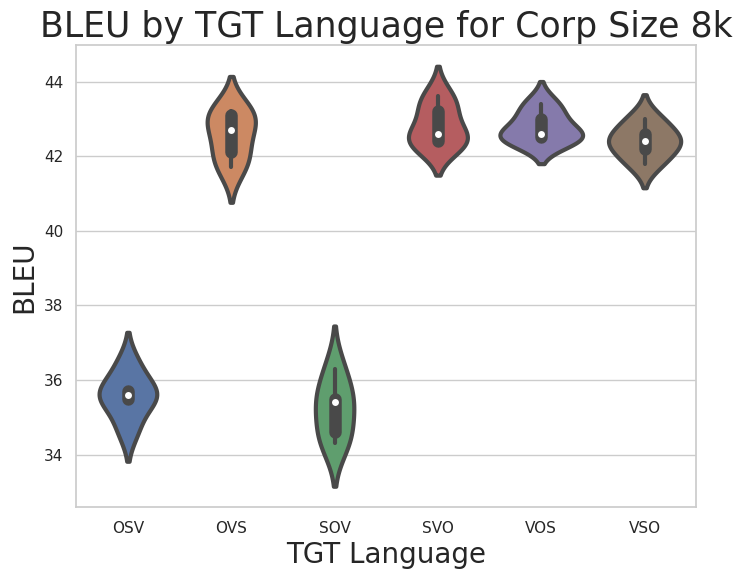

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 8k'}, xlabel='TGT Language', ylabel='BLEU'>

In [147]:
violinplot(df_8k['tgt'], df_8k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 8k')

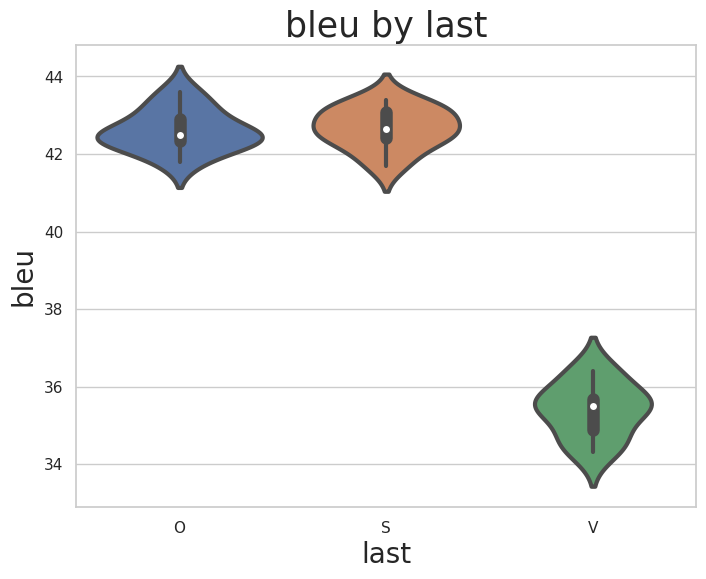

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [124]:
violinplot(df_8k['last'], df_8k['bleu'], xlabel = "last", ylabel='bleu')

In [125]:
grouped = df_8k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

,src,Mean,Range,Variance
0,OSV,41.64,8.2,12.228
1,OVS,40.26,7.1,12.848
2,SOV,40.84,8.0,11.903
3,SVO,39.26,8.2,15.773
4,VOS,39.98,7.7,16.087
5,VSO,39.38,7.8,15.737


In [126]:
grouped = df_8k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('tgt')

,tgt,Mean,Range,Variance
0,OSV,35.58,1.7,0.367
1,OVS,42.56,1.5,0.418
2,SOV,35.22,2.0,0.627
3,SVO,42.82,1.3,0.312
4,VOS,42.78,1.0,0.172
5,VSO,42.40,1.2,0.200


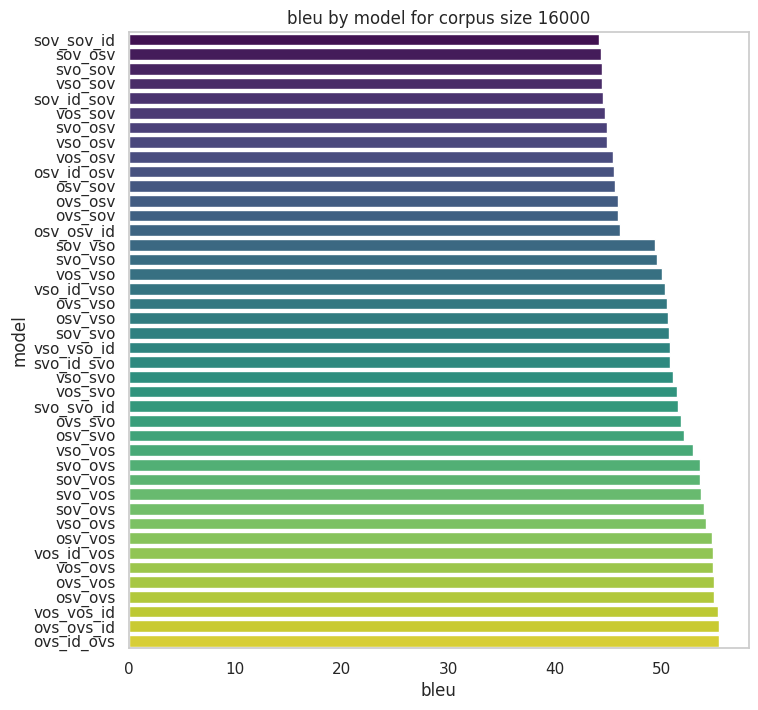

In [127]:
plot_by_len(df, 16000)

In [128]:
df_16k = df[(df['corpus_length'] == 16000) & (df['is_id'] == False)].drop(['is_id', 'normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_16k.head()

,src,tgt,bleu,num_steps,name,last
126,SVO,SOV,44.4,16302,svo_sov,V
127,SVO,VSO,49.6,13452,svo_vso,O
128,SVO,VOS,53.7,19494,svo_vos,S
129,SVO,OSV,44.9,19228,svo_osv,V
130,SVO,OVS,53.6,13884,svo_ovs,S


In [129]:
df_16k.describe()['bleu']

count    30.000000
mean     49.963333
std       3.880409
min      44.300000
25%      45.675000
50%      50.650000
75%      53.600000
max      54.900000
Name: bleu, dtype: float64

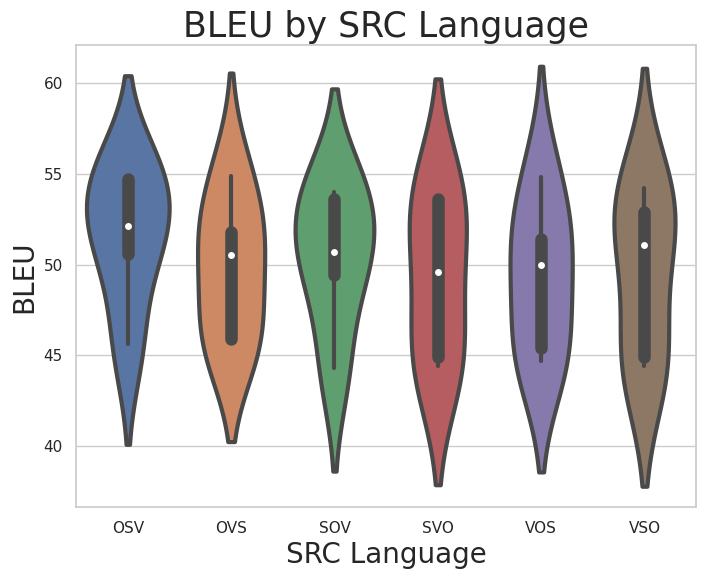

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [130]:
violinplot(df_16k['src'], df_16k['bleu'], xlabel = 'SRC Language', ylabel = "BLEU")

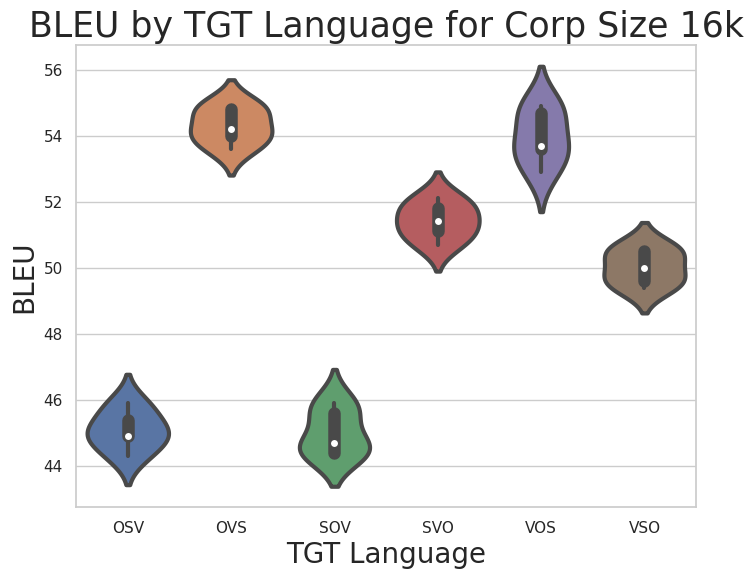

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 16k'}, xlabel='TGT Language', ylabel='BLEU'>

In [148]:
violinplot(df_16k['tgt'], df_16k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 16k')

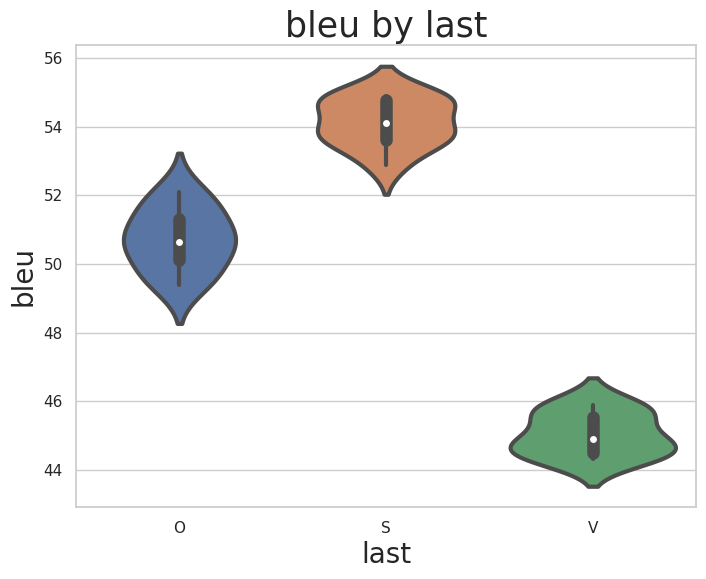

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [132]:
violinplot(df_16k['last'], df_16k['bleu'], xlabel = "last", ylabel='bleu')

In [133]:
grouped = df_16k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

,src,Mean,Range,Variance
0,OSV,51.58,9.3,14.437
1,OVS,49.80,9.0,15.230
2,SOV,50.40,9.7,15.375
3,SVO,49.24,9.3,20.323
4,VOS,49.26,10.1,17.878
5,VSO,49.50,9.8,20.845


In [134]:
grouped = df_16k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('tgt')

,tgt,Mean,Range,Variance
0,OSV,45.08,1.6,0.362
1,OVS,54.30,1.3,0.300
2,SOV,45.00,1.5,0.495
3,SVO,51.42,1.4,0.307
4,VOS,53.96,2.0,0.688
5,VSO,50.02,1.2,0.282


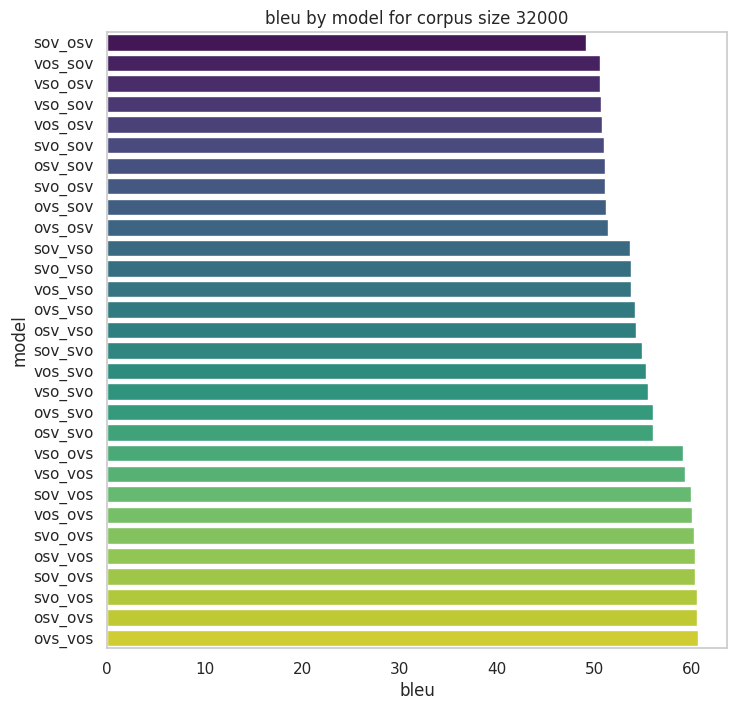

In [135]:
plot_by_len(df, 32000)

In [136]:
df_32k = df[(df['corpus_length'] == 32000) & (df['is_id'] == False)].drop(['is_id', 'normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_32k.head()

,src,tgt,bleu,num_steps,name,last
168,SVO,SOV,51.0,34114,svo_sov,V
169,SVO,VSO,53.8,30514,svo_vso,O
170,SVO,VOS,60.5,26499,svo_vos,S
171,SVO,OSV,51.1,32047,svo_osv,V
172,SVO,OVS,60.2,22792,svo_ovs,S


In [137]:
df_32k.describe()['bleu']

count    30.000000
mean     55.193333
std       3.938312
min      49.100000
25%      51.125000
50%      54.600000
75%      59.750000
max      60.600000
Name: bleu, dtype: float64

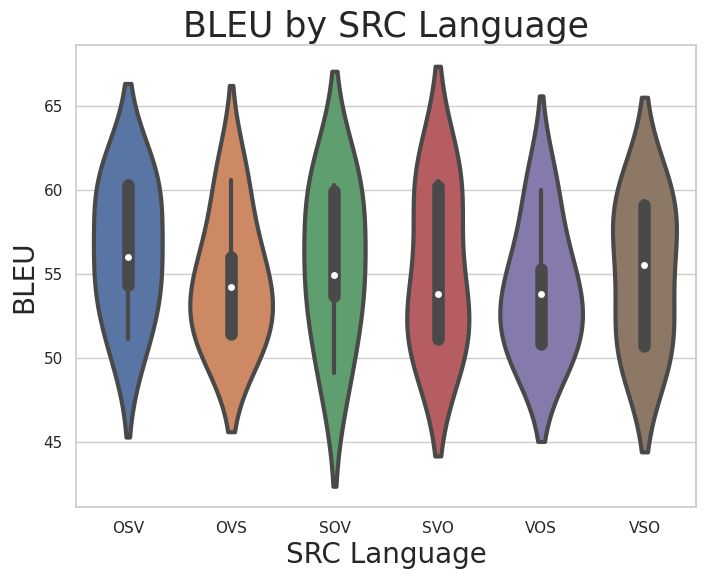

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [138]:
violinplot(df_32k['src'], df_32k['bleu'], xlabel = 'SRC Language', ylabel = "BLEU")

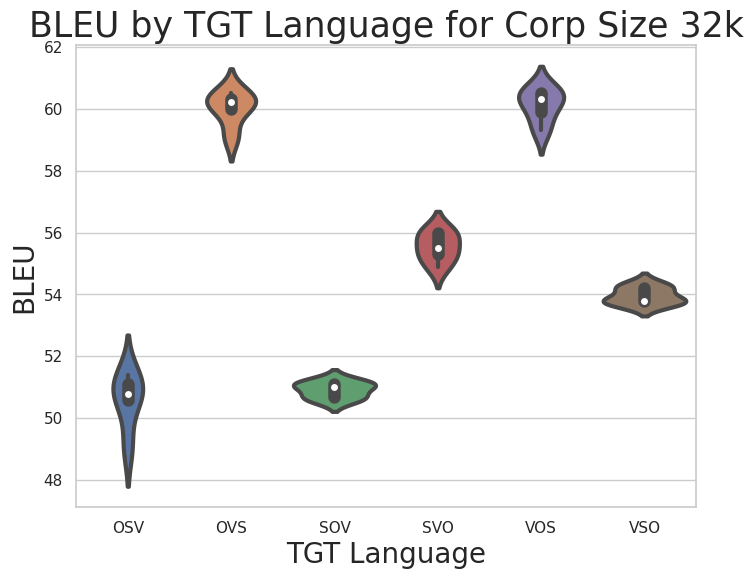

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 32k'}, xlabel='TGT Language', ylabel='BLEU'>

In [149]:
violinplot(df_32k['tgt'], df_32k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 32k')

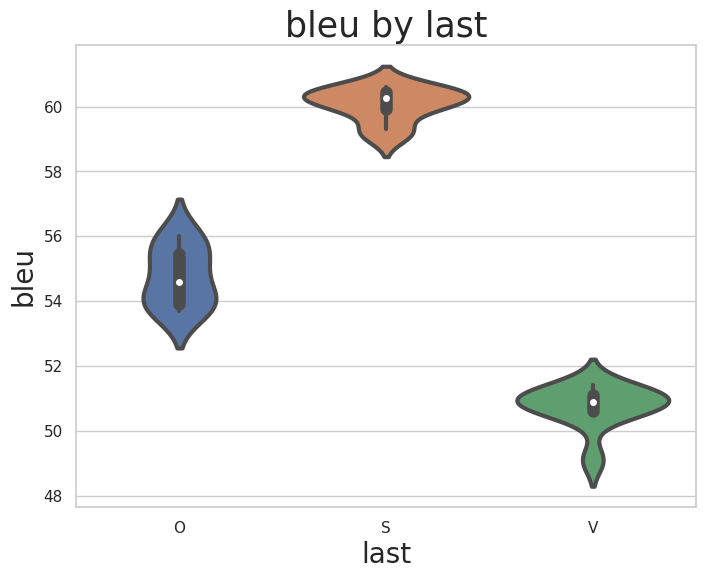

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [142]:
violinplot(df_32k['last'], df_32k['bleu'], xlabel = "last", ylabel='bleu')

In [140]:
grouped = df_32k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

,src,Mean,Range,Variance
0,OSV,56.44,9.4,16.168
1,OVS,54.68,9.4,14.972
2,SOV,55.58,11.2,21.732
3,SVO,55.32,9.5,22.357
4,VOS,54.10,9.4,14.870
5,VSO,55.04,8.7,18.348


In [141]:
grouped = df_32k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('tgt')

,tgt,Mean,Range,Variance
0,OSV,50.60,2.3,0.795
1,OVS,60.02,1.4,0.297
2,SOV,50.92,0.6,0.067
3,SVO,55.54,1.1,0.223
4,VOS,60.12,1.3,0.282
5,VSO,53.96,0.6,0.073


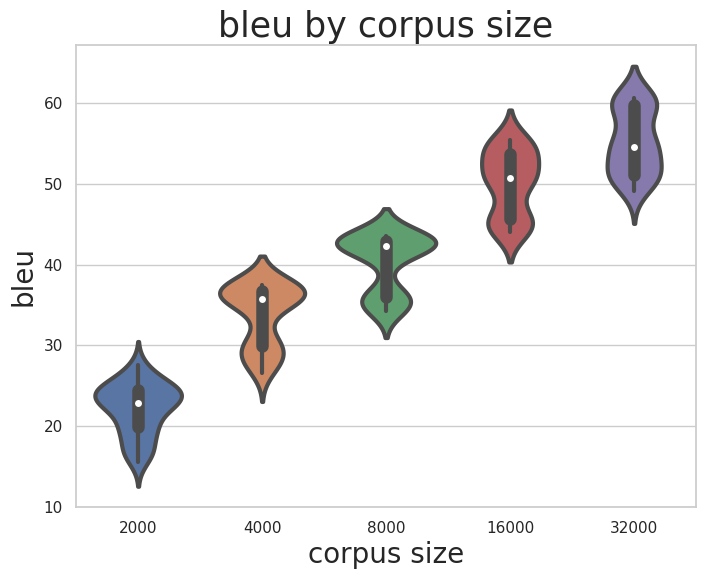

<Axes: title={'center': 'bleu by corpus size'}, xlabel='corpus size', ylabel='bleu'>

In [143]:
violinplot(df['corpus_length'], df['bleu'], xlabel='corpus size', ylabel='bleu')

**Analysis:**
- Clearly corpus size helps
- The distribution within each is bimodal (since 4 good 2 bad type of deal)

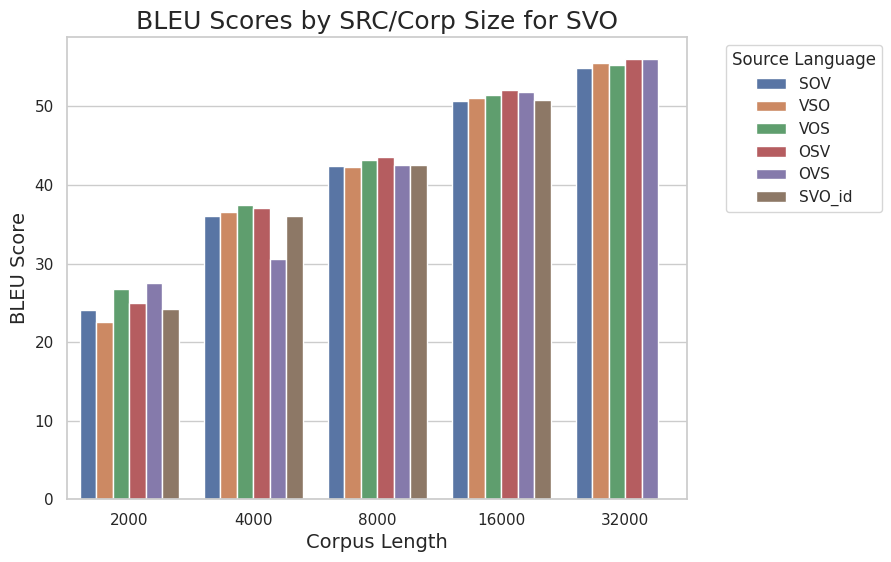

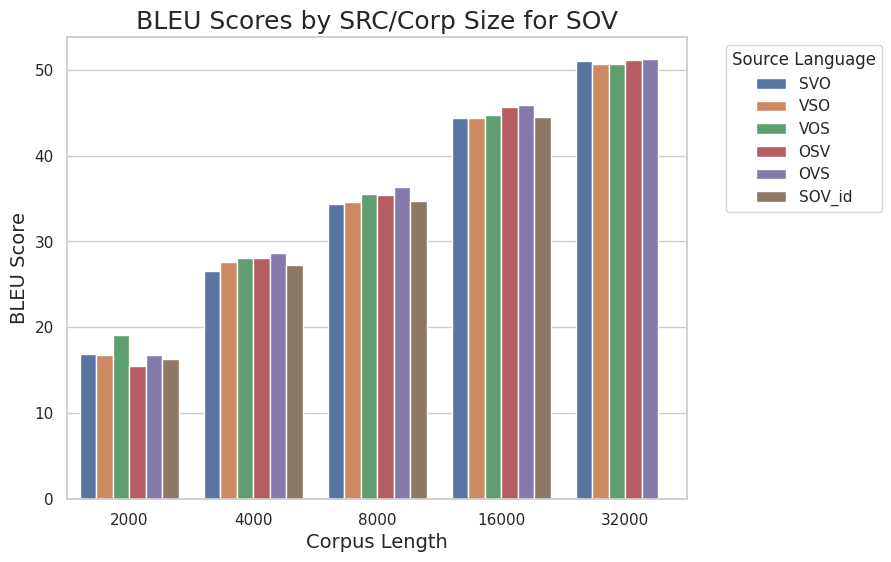

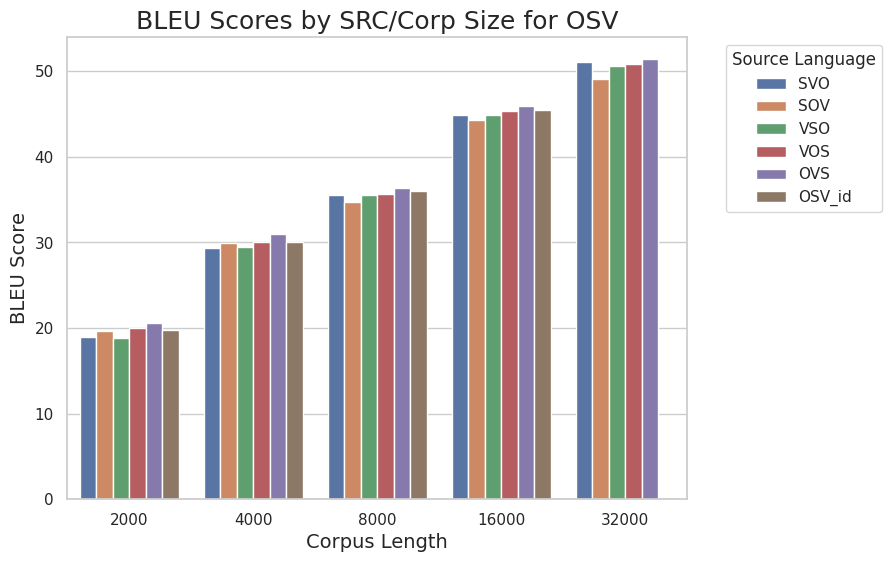

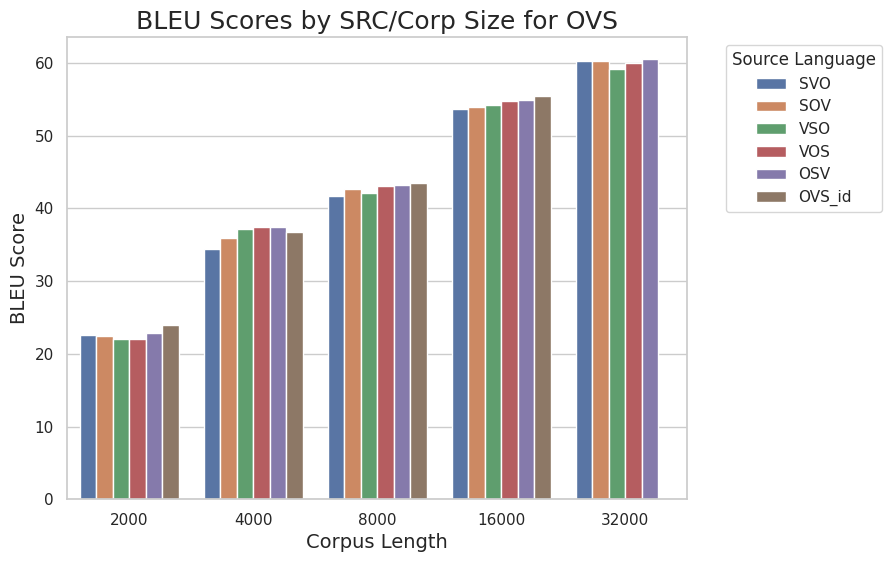

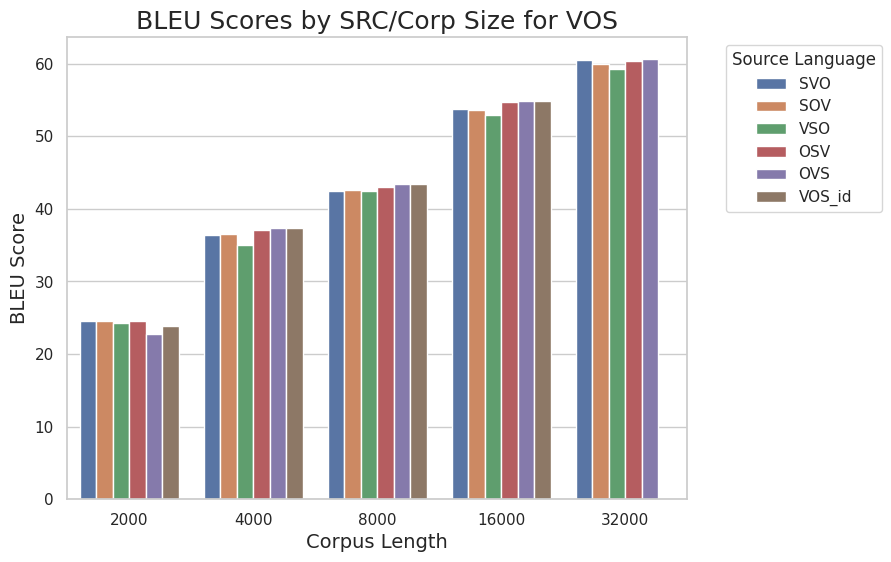

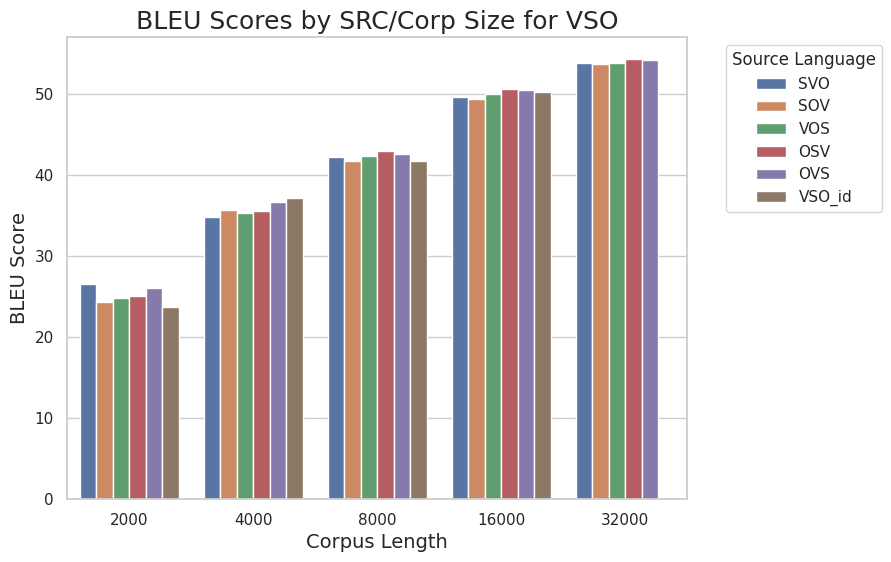

In [144]:
for perm in ['SVO', "SOV", "OSV", "OVS", "VOS", "VSO"]:
    two_factor_plot(df, perm)

<a id='2'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Data Variability Analysis </strong> </p>

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
In the data variability experiment, we are investigating the variability of results. We generated 5 testperanto SVO datasets of size 2000 in parallel (so different voicebox but same language) and trained pairwise 2 (5C2) = 20 models. In theory, the BLEU should be very similar, but this is just to give us some clarity on whether or not that's actually true.
</p>

In [ ]:
df = get_data('data_variability')

df.head()

,corpus_length,src,tgt,bleu,chrF2,num_steps,name,is_id,normalized_steps
0,2000,SVO1,SVO2,24.6,58.0,3270,svo1_svo2,False,1.635
1,2000,SVO1,SVO3,26.9,59.2,3624,svo1_svo3,False,1.812
2,2000,SVO1,SVO4,26.6,59.4,5340,svo1_svo4,False,2.670
3,2000,SVO1,SVO5,26.0,59.5,4296,svo1_svo5,False,2.148
4,2000,SVO2,SVO3,24.9,58.1,3144,svo2_svo3,False,1.572


: 

: 

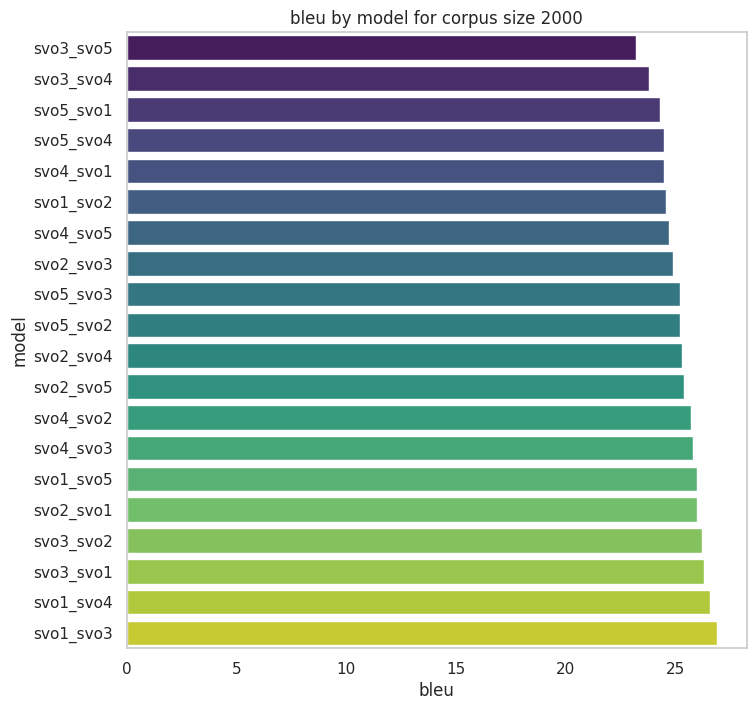

: 

: 

In [ ]:
plot_by_len(df, 2000)

**Analysis:**
- The variability here is much lower.

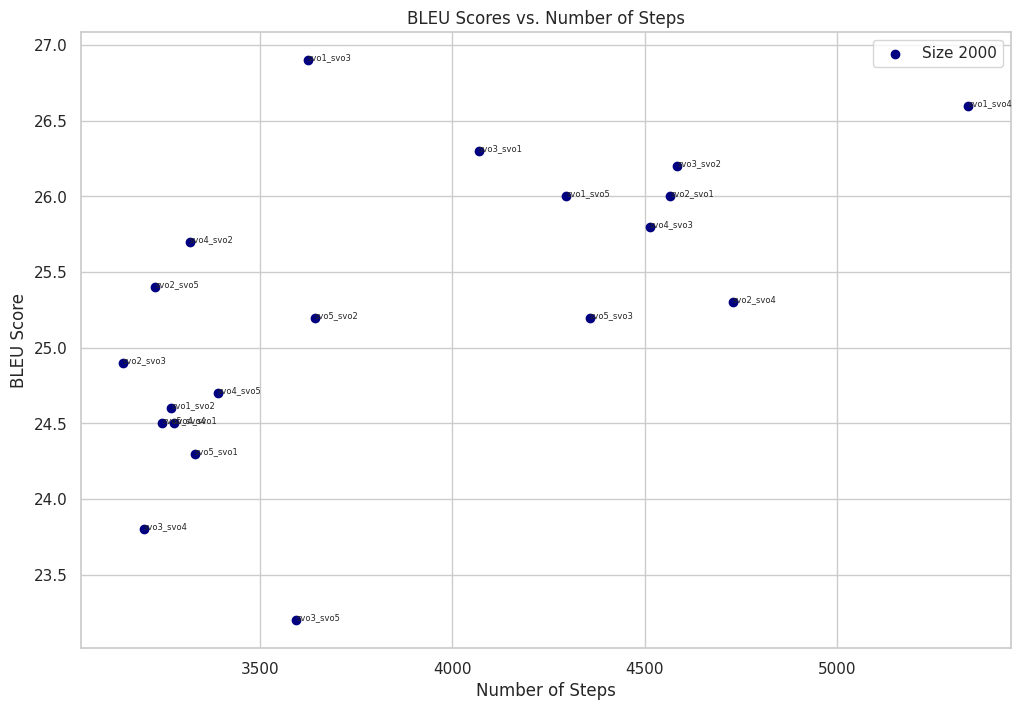

: 

: 

In [ ]:
plot_score_vs_steps(df)

: 

: 